# Generation of λ-Nets for I-Net training

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes



config = {
    'function_family': {
        'maximum_depth': 3,
        'fully_grown': True,                      
    },
    'data': {
        'number_of_variables': 3, 
        'num_classes': 2,
        
        'function_generation_type': 'random_decision_tree', # 'make_classification' 'random_decision_tree'
        'objective': 'classification', # 'regression'
        
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform',       
                
        'lambda_dataset_size': 5000, #number of samples per function
        'number_of_generated_datasets': 10000,
        
        'noise_injected_level': 0, 
        'noise_injected_type': 'flip_percentage', # '' 'normal' 'uniform' 'normal_range' 'uniform_range'
    }, 
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True, 
        'early_stopping_min_delta_lambda': 1e-2,
        'batch_lambda': 64,
        'dropout_lambda': 0,
        'lambda_network_layers': [64],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'binary_crossentropy', #categorical_crossentropy
        
        'number_of_lambda_weights': None,
        
        'number_initializations_lambda': 1, 
        
        'number_of_trained_lambda_nets': 10000
    },     
    'evaluation': {   
        #'inet_holdout_seed_evaluation': False,
            
        'random_evaluation_dataset_size': 500,
    },    
    
    'computation':{
        'n_jobs': -5,
        'use_gpu': False,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}




In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
from itertools import product       # forms cartesian products
from tqdm import tqdm_notebook as tqdm
from more_itertools import random_product 
import pickle
import numpy as np
import pandas as pd
import timeit
import matplotlib.pyplot as plt 
import time
import math
import operator
from functools import reduce

from scipy.signal import argrelextrema

import sys
import os

import shutil

import logging
logging.getLogger('tensorflow').disabled = True

import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

from joblib import Parallel, delayed


from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score
from similaritymeasures import frechet_dist, area_between_two_curves, dtw
from IPython.display import Image

from livelossplot import PlotLossesKerasTF

import seaborn as sns

import tensorflow as tf
import tensorflow_addons as tfa
import random 


import keras
import tensorflow.keras.backend as K
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau



In [4]:
#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################
    
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''

sns.set_style("darkgrid")

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 200)
np.set_printoptions(threshold=200)

warnings.filterwarnings('ignore')

In [5]:
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################

config['lambda_net']['number_of_lambda_weights'] = get_number_of_lambda_net_parameters(lambda_network_layers, number_of_variables, num_classes)
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

#initialize_utility_functions_config_from_curent_notebook(config)
#initialize_LambdaNet_config_from_curent_notebook(config)
#initialize_metrics_config_from_curent_notebook(config)

#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(config, path_type='lambda_net'))
generate_directory_structure()
generate_lambda_net_directory(config)

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

In [6]:
print(path_identifier_lambda_net_data)

print(path_identifier_function_data)


lNetSize5000_numLNets10000_var3_class2_random_decision_tree_xMax1_xMin0_xDistuniform_depth3_fullyGrown/64_e1000ES0.01_b64_drop0_adam_binary_crossentropy_fixedInit1-seed42
lNetSize5000_numDatasets10000_var3_class2_random_decision_tree_xMax1_xMin0_xDistuniform_depth3_fullyGrown


In [7]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


In [8]:
lambda_network_layers

[64]

In [9]:
path_functions = './data/saved_function_lists/functions_' + path_identifier_function_data + '.csv'
function_df = pd.read_csv(path_functions)

path_X_data = './data/saved_function_lists/X_data_' + path_identifier_function_data + '.pkl'
with open(path_X_data, 'rb') as f:
    X_data_list = pickle.load(f)
    
path_y_data = './data/saved_function_lists/y_data_' + path_identifier_function_data + '.pkl'
with open(path_y_data, 'rb') as f:
    y_data_list = pickle.load(f)
    
if number_of_trained_lambda_nets < number_of_generated_datasets:
    function_df = function_df.sample(n=number_of_trained_lambda_nets, random_state=RANDOM_SEED)
    random.seed(RANDOM_SEED)
    X_data_list = random.sample(X_data_list, number_of_trained_lambda_nets)
    random.seed(RANDOM_SEED)
    y_data_list = random.sample(y_data_list, number_of_trained_lambda_nets)
    random.seed(RANDOM_SEED)

## Data Inspection

In [10]:
function_df.head()

,f0v0,f0v1,f0v2,f1v0,f1v1,f1v2,f2v0,f2v1,f2v2,f3v0,f3v1,f3v2,f4v0,f4v1,f4v2,f5v0,f5v1,f5v2,f6v0,f6v1,f6v2,b0,b1,b2,b3,b4,b5,b6,lp0c0,lp0c1,lp1c0,lp1c1,lp2c0,lp2c1,lp3c0,lp3c1,lp4c0,lp4c1,lp5c0,lp5c1,lp6c0,lp6c1,lp7c0,lp7c1
0,-0.004,0.310,-0.475,-0.425,-0.222,0.155,-0.011,0.458,-0.051,0.153,-0.174,-0.113,-0.552,-0.382,-0.238,0.021,0.228,0.346,-0.391,-0.251,0.210,0.479,-0.119,0.432,-0.093,0.061,0.523,-0.536,-0.223,-0.206,-0.090,0.304,-0.138,0.158,0.305,0.171,-0.229,0.019,-0.163,-0.181,-0.247,0.060,-0.331,-0.330
1,0.186,0.139,0.376,-0.102,-0.234,-0.555,-0.547,0.389,-0.149,0.084,-0.102,-0.026,0.191,-0.031,0.019,0.297,0.125,-0.291,-0.456,-0.414,-0.122,0.337,0.192,0.497,0.260,-0.170,0.006,0.223,0.339,-0.064,0.052,0.003,0.031,0.152,0.258,-0.116,-0.056,0.309,-0.093,0.033,-0.195,0.245,0.187,0.322
2,0.132,-0.137,0.158,-0.029,0.247,0.137,-0.066,-0.467,0.132,-0.511,0.076,0.038,-0.127,0.472,0.039,0.239,0.244,-0.341,-0.222,0.555,-0.566,-0.039,-0.046,0.410,-0.055,0.152,-0.028,-0.323,-0.200,0.155,-0.172,-0.136,-0.321,-0.078,-0.229,-0.194,0.083,-0.111,0.233,-0.328,0.017,0.151,-0.162,0.137
3,0.208,0.424,0.148,-0.253,0.289,0.253,0.316,0.282,0.065,-0.356,0.314,0.515,-0.208,-0.465,0.510,0.345,0.475,-0.419,0.432,-0.367,0.019,-0.150,0.396,0.197,0.309,-0.041,0.124,-0.404,-0.085,0.135,0.111,0.252,0.187,0.179,-0.098,-0.003,0.236,-0.152,-0.313,0.303,0.107,0.192,0.042,-0.325
4,-0.107,-0.171,-0.358,0.472,0.440,-0.213,-0.141,-0.269,-0.279,0.078,0.077,-0.227,0.041,0.186,-0.215,0.108,-0.285,-0.214,-0.267,-0.337,0.432,0.044,0.530,0.145,-0.491,0.461,0.064,-0.053,-0.044,-0.151,0.106,0.115,0.268,-0.048,0.317,-0.071,-0.180,0.144,-0.064,0.103,-0.115,-0.232,-0.003,0.035


In [11]:
X_data_list[0][0].head(10)

f0v0   -0.004
f0v1    0.310
f0v2   -0.475
f1v0   -0.425
f1v1   -0.222
f1v2    0.155
f2v0   -0.011
f2v1    0.458
f2v2   -0.051
f3v0    0.153
dtype: float32

In [12]:
X_data_list[0][1].head(10)

,x0,x1,x2
0,0.549,0.715,0.603
1,0.545,0.424,0.646
2,0.438,0.892,0.964
3,0.383,0.792,0.529
4,0.568,0.926,0.071
5,0.087,0.020,0.833
6,0.778,0.870,0.979
7,0.799,0.461,0.781
8,0.118,0.640,0.143
9,0.945,0.522,0.415


In [13]:
y_data_list[0][0].head(10)

f0v0   -0.004
f0v1    0.310
f0v2   -0.475
f1v0   -0.425
f1v1   -0.222
f1v2    0.155
f2v0   -0.011
f2v1    0.458
f2v2   -0.051
f3v0    0.153
dtype: float32

In [14]:
y_data_list[0][1].head(10)

,result
0,0
1,0
2,0
3,0
4,0
5,1
6,0
7,0
8,0
9,0


In [15]:
def inject_noise(y_data, noise=0.0, noise_dist='normal', seed=42):
    """
    Returns a polynomial injected with specified noise type and amount. 
    Inputs a clean polynomial array with x-data and y-data and modifies the y-data according to the noise settings.
    """
    np.random.seed(seed)
    
    #Calculate range of function values of input polynomial
    range_values_fv = np.ptp(y_data[1].values)
    
    #Selection of noise type
    #Available types: normal, uniform, A, B, C
    if noise_dist=='normal':
        noise_sample=noise*np.random.normal(loc=0, scale=1.0,size=y_data[1].shape[0])
    elif noise_dist=='uniform':
        noise_sample=noise*np.random.uniform(low=0, high=1.0,size=y_data[1].shape[0])
    elif noise_dist=='normal_range':
        #Normal distribution adjusted to function value range
        noise_sample=(noise*range_values_fv)*np.random.normal(loc=0, scale=1.0,size=y_data[1].shape[0])
    elif noise_dist=='uniform_range':
        noise_sample=(noise*range_values_fv)*np.random.normal(loc=0, scale=1.0,size=y_data[1].shape[0])
    elif noise_dist=='flip_percentage':
        idx = np.random.choice(y_data[1].shape[0], int(y_data[1].shape[0]*noise), replace=False)
        y_data[1].iloc[idx] = (y_data[1].iloc[idx] + 1) % 2 
        #y_data[1].reshape(-1, 1)
        return y_data
    else:
        #no noise
        noise_sample = np.zeros(y_data[1].shape[0])
                               
    noise_sample=noise_sample.reshape(-1,1)
    
    y_data[1]=y_data[1]+noise_sample
    
    return np.clip(y_data, 0, 1)

In [16]:
if noise_injected_level > 0:
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky')
    y_data_list = parallel(delayed(inject_noise)(y_data=y_data_list[i],
                                                 noise=noise_injected_level,
                                                 noise_dist=noise_injected_type, 
                                                 seed=RANDOM_SEED+i) for i in range(len(y_data_list)))


In [17]:
y_data_list[0][0].head(10)

f0v0   -0.004
f0v1    0.310
f0v2   -0.475
f1v0   -0.425
f1v1   -0.222
f1v2    0.155
f2v0   -0.011
f2v1    0.458
f2v2   -0.051
f3v0    0.153
dtype: float32

In [18]:
y_data_list[0][1].head(10)

,result
0,0
1,0
2,0
3,0
4,0
5,1
6,0
7,0
8,0
9,0


## Lambda Network Training + Weigh/Bias saving

In [19]:
#%load_ext autoreload

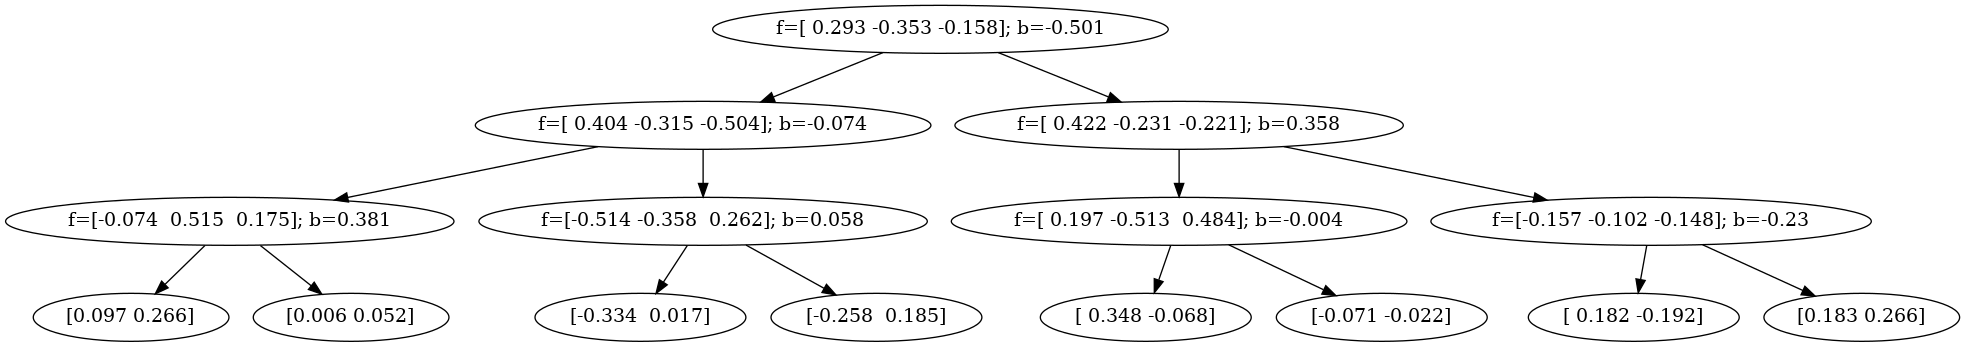

In [20]:
rand_index = np.random.randint(number_of_trained_lambda_nets)

rand_tree = generate_decision_tree_from_array(y_data_list[rand_index][0].values, config)
rand_tree.plot_tree()

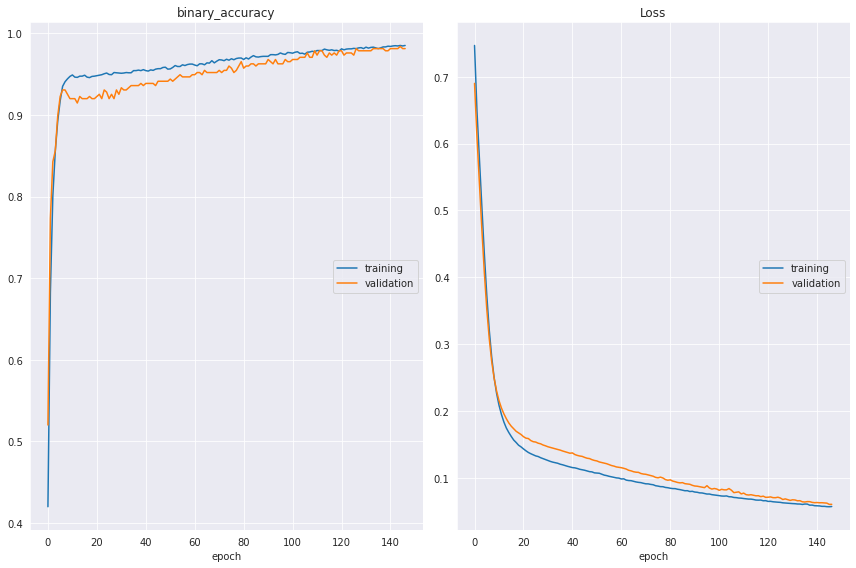

binary_accuracy
	training         	 (min:    0.420, max:    0.985, cur:    0.985)
	validation       	 (min:    0.520, max:    0.984, cur:    0.981)
Loss
	training         	 (min:    0.057, max:    0.747, cur:    0.057)
	validation       	 (min:    0.060, max:    0.690, cur:    0.060)


In [21]:
#%autoreload 2
random_network = train_lambda_net(config=config,
                                  lambda_index=rand_index, 
                                  X_data_with_function=X_data_list[rand_index], 
                                  y_data_with_function=y_data_list[rand_index], 
                                  callbacks=[PlotLossesKerasTF()], 
                                  return_model=True,
                                  printing=False)

In [ ]:
#%autoreload 2
parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky') #loky
clf_list = parallel(delayed(train_lambda_net)(config=config,
                                              lambda_index=index, 
                                              X_data_with_function=X_data, 
                                              y_data_with_function=y_data,
                                              return_history=True, 
                                              printing=True) for index, (X_data, y_data) in enumerate(zip(X_data_list, y_data_list)))  
del parallel

[Parallel(n_jobs=-5)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-5)]: Done  88 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-5)]: Done 248 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-5)]: Done 472 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-5)]: Done 760 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-5)]: Done 1112 tasks      | elapsed: 14.7min


In [ ]:
random_network['model'].get_config()

In [ ]:
random_network['model'].summary()

## Save and Plot Lambda-Model History

In [ ]:
loss_list_total = []
metric_list_total = []

val_loss_list_total = []
val_metric_list_total = []

index_list = []


max_training_epochs = 0
for _, entry in tqdm(enumerate(clf_list)):
    history = entry['history']
    
    current_training_epochs = len(history[list(history.keys())[0]])
    max_training_epochs = max(max_training_epochs, current_training_epochs)


for _, entry in tqdm(enumerate(clf_list)):
    history = entry['history']
    index = entry['index']
    
    current_training_epochs = len(history[list(history.keys())[0]])
    
    loss_list = np.full(max_training_epochs, np.nan)
    metric_list = np.full(max_training_epochs, np.nan)
    val_loss_list = np.full(max_training_epochs, np.nan)
    val_metric_list = np.full(max_training_epochs, np.nan) 

    for i in range(current_training_epochs):  
        loss_list[i] = history[list(history.keys())[0]][i]
        metric_list[i] = history[list(history.keys())[1]][i]
        val_loss_list[i] = history[list(history.keys())[len(history.keys())//2]][i]
        val_metric_list[i] = history[list(history.keys())[len(history.keys())//2+1]][i]
    
    index_list.append([index])
    loss_list_total.append(loss_list)
    metric_list_total.append(metric_list)
    val_loss_list_total.append(val_loss_list)
    val_metric_list_total.append(val_metric_list)

loss_df = pd.DataFrame(data=np.hstack([index_list, loss_list_total]), columns=flatten_list(['index', [list(history.keys())[0] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]]))
#loss_df['index'] = loss_df['index'].astype(int)
metric_df = pd.DataFrame(data=np.hstack([index_list, metric_list_total]), columns=flatten_list(['index', [list(history.keys())[1] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]]))
#metric_df['index'] = metric_df['index'].astype(int)
val_loss_df = pd.DataFrame(data=np.hstack([index_list, val_loss_list_total]), columns=flatten_list(['index', [list(history.keys())[len(history.keys())//2] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]]))
#val_loss_df['index'] = val_loss_df['index'].astype(int)
val_metric_df = pd.DataFrame(data=np.hstack([index_list, val_metric_list_total]), columns=flatten_list(['index', [list(history.keys())[len(history.keys())//2+1] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]])) 
#val_metric_df['index'] = val_metric_df['index'].astype(int)


In [ ]:
path_loss = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[0] + '.txt'
path_metric = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[1] + '.txt'
path_val_loss = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[len(history.keys())//2] + '.txt'
path_val_metric = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[len(history.keys())//2+1] + '.txt'

loss_df.to_csv(path_loss, index=None, sep=',')
metric_df.to_csv(path_metric, index=None, sep=',')
val_loss_df.to_csv(path_val_loss, index=None, sep=',')
val_metric_df.to_csv(path_val_metric, index=None, sep=',')


In [ ]:
loss_df.describe()

In [ ]:
val_loss_df.describe()

In [ ]:
metric_df.describe()

In [ ]:
val_metric_df.describe()

In [ ]:
# summarize history for metric
path = './data/results/weights_' + path_identifier_lambda_net_data + '/' + list(history.keys())[1] + '.png'

adjustment_threshold_metric = 10#100
    
metric_df_adjusted = metric_df.copy(deep=True).iloc[:,1:]
if adjustment_threshold_metric > 0:
    metric_df_adjusted[metric_df_adjusted.columns] = np.where(metric_df_adjusted[metric_df_adjusted.columns] > adjustment_threshold_metric, adjustment_threshold_metric, metric_df_adjusted[metric_df_adjusted.columns])
    
val_metric_df_adjusted = val_metric_df.copy(deep=True).iloc[:,1:]
if adjustment_threshold_metric > 0:
    val_metric_df_adjusted[val_metric_df_adjusted.columns] = np.where(val_metric_df_adjusted[val_metric_df_adjusted.columns] > adjustment_threshold_metric, adjustment_threshold_metric, val_metric_df_adjusted[val_metric_df_adjusted.columns])

    
plt.plot(metric_df_adjusted.describe().loc['mean'].values)
plt.plot(val_metric_df_adjusted.describe().loc['mean'].values)
plt.title('model ' + list(history.keys())[1])
plt.ylabel(list(history.keys())[1])
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig(path)
plt.show()


In [ ]:
# summarize history for loss
path = './data/results/weights_' + path_identifier_lambda_net_data + '/' + list(history.keys())[0] + '.png'

adjustment_threshold_loss = 0#10000
    
loss_df_adjusted = loss_df.copy(deep=True).iloc[:,1:]

if adjustment_threshold_loss > 0:
    loss_df_adjusted[loss_df_adjusted.columns] = np.where(loss_df_adjusted[loss_df_adjusted.columns] > adjustment_threshold_loss, adjustment_threshold_loss, loss_df_adjusted[loss_df_adjusted.columns])
    
val_loss_df_adjusted = val_loss_df.copy(deep=True).iloc[:,1:]
if adjustment_threshold_loss > 0:
    val_loss_df_adjusted[val_loss_df_adjusted.columns] = np.where(val_loss_df_adjusted[val_loss_df_adjusted.columns] > adjustment_threshold_loss, adjustment_threshold_loss, val_loss_df_adjusted[val_loss_df_adjusted.columns])

    
plt.plot(loss_df_adjusted.describe().loc['mean'].values)
plt.plot(val_loss_df_adjusted.describe().loc['mean'].values)
plt.title('model ' + list(history.keys())[0])
plt.ylabel(list(history.keys())[0])
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig(path)
plt.show()
